# Stanford Open Policing Data - Nashville, TN Analysis

## Team: The Brent Spiners

- Kyle Absten
- Ramo Tucakovic
- Ranjita Kaur
- Juan Gutierrez

## Introduction

For our final project, we got our hands on a hefty dataset from Stanford University's Open Policing project, specifically traffic stop data from Nashville, Tennessee. We chose the dataset from Nasheville TN because it contained a good amount of entries (~3m), with the most complete feature set. Our goal was to build a model that can predict the outcome of these stops: either a warning or something more serious, like a ticket or arrest. This will be a classification solution with only two possible outcomes" WARNING or INFRACTION, with infraction encompassing tickets and/or arrests. We want to create a data-driven model to predict the outcome of a traffic stop and investigate which factors are most important to that model. 

We begin importing the relevant libraries for our project.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import graphviz
import pgeocode
import re
import requests
import time
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance

## Selection of Data
#### Source of the Data
The data we chose can be found here: https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_tn_nashville_2020_04_01.csv.zip

Consider loading the data from a local CSV file, as the download takes several minutes.


In [2]:
dataset_path = 'https://stacks.stanford.edu/file/druid:yg821jf8611/yg821jf8611_tn_nashville_2020_04_01.csv.zip'
df = pd.read_csv(dataset_path, low_memory=False)

#### Data Exploration

In [3]:
df.info()
df.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092351 entries, 0 to 3092350
Data columns (total 42 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   raw_row_number                  object 
 1   date                            object 
 2   time                            object 
 3   location                        object 
 4   lat                             float64
 5   lng                             float64
 6   precinct                        object 
 7   reporting_area                  float64
 8   zone                            object 
 9   subject_age                     float64
 10  subject_race                    object 
 11  subject_sex                     object 
 12  officer_id_hash                 object 
 13  type                            object 
 14  violation                       object 
 15  arrest_made                     object 
 16  citation_issued                 object 
 17  warning_issued             

,raw_row_number,date,time,location,lat,lng,precinct,reporting_area,zone,subject_age,...,raw_traffic_citation_issued,raw_misd_state_citation_issued,raw_suspect_ethnicity,raw_driver_searched,raw_passenger_searched,raw_search_consent,raw_search_arrest,raw_search_warrant,raw_search_inventory,raw_search_plain_view
2923723,1860668,2014-09-14,01:29:00,"MYATT DR & MYATT DR, MADISON, TN, 37115",36.279954,-86.691211,7,1715.0,715,25.0,...,False,False,N,False,False,False,False,False,False,False
2702709,2215034,2015-08-13,11:33:00,"BRILEY PKWY N & MURFREESBORO PIKE, NASHVILLE, ...",36.122074,-86.702419,3,8831.0,315,66.0,...,True,False,N,False,False,False,False,False,False,False
635941,1555104,2013-12-24,08:17:00,"S 7TH ST & SYLVAN ST, NASHVILLE, TN, 37206",36.168169,-86.757240,2,1043.0,211,39.0,...,False,False,N,False,False,False,False,False,False,False


Looking at our dataset, we have 42 different features. 1 feature is boolean, 4 are numeric and the remaining 37 are object. Not all of these features will be helpful to predict whether a future police interaction will result in an infraction or not. A few thoughts on some of the features in our dataset:

raw_row_number- From the doumentation: "A number used to join clean data back to the raw data". For our purposes this is not needed.

date- This is the date of the stop. We will look at converting this feature to day_of_week, and see if there is any predictive correlation between the day of the week and whether an infraction is given.

location, lat, long, precint, reporting_area, zone- These are all variable that deal with where the stop happened and/or the specific police department involved in the stop. It's likely that we will need to drop some of these columns, as they appear to be mostly repetitive data.

officer_id_hash- This is an identifier for the officer involved in the stop. From the documention

type- From documentation: "Type of stop: vehicular or pedestrian."

violation- From documentation: "Specific violation of stop where provided. What is recorded here varies widely across police departments." Will need to investigate further.

arrest_made, citation_issued, warning_issued, outcome- These are all outcomes of the stop. Because we are only aiming to predict whether the driver will result in an infraction(anything greater than a warning), all of these features can be combined into one: outcome. This will be our target variable.

contraband_found, contraband_drugs, contraband_weapons- These are all variables related to the subject being found to have illegal items.
Need to investigate more to decide whether to include these in the model.

search_conducted, search_person, search_vehicle, search_basis- Similar to contraband data, needs further investigation.

notes- From documentation: "A freeform text field containing any officer notes." Needs further look, but likely needs to be dropped

raw_verbal_warning_issued, raw_written_warning_issued, raw_traffic_citation_issued, raw_misd_state_citation_issued, raw_suspect_ethnicity,
raw_driver_searched, raw_passenger_searched, raw_search_consent, raw_search_arrest, raw_search_warrant, raw_search_inventory,
raw_search_plain_view- These are all raw versions of other variables in the dataset and can therefore be dropped.


Overall, our dataset is primarily categorical data. Knowing this, we will likely use a decision tree for our model.

#### Preprocessing and Preparing Data for Modeling

In [4]:
features_to_drop = ['raw_row_number', 'raw_verbal_warning_issued', 'raw_written_warning_issued', 'raw_traffic_citation_issued', 'raw_misd_state_citation_issued', 'raw_suspect_ethnicity', 'raw_driver_searched', 'raw_passenger_searched', 'raw_search_consent', 'raw_search_arrest', 'raw_search_warrant', 'raw_search_inventory', 'raw_search_plain_view']
df.drop(features_to_drop,axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092351 entries, 0 to 3092350
Data columns (total 29 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date                        object 
 1   time                        object 
 2   location                    object 
 3   lat                         float64
 4   lng                         float64
 5   precinct                    object 
 6   reporting_area              float64
 7   zone                        object 
 8   subject_age                 float64
 9   subject_race                object 
 10  subject_sex                 object 
 11  officer_id_hash             object 
 12  type                        object 
 13  violation                   object 
 14  arrest_made                 object 
 15  citation_issued             object 
 16  warning_issued              object 
 17  outcome                     object 
 18  contraband_found            object 
 19  contraband_drugs     

This cuts our feature set from 42 to 29.
Now we will look at the remaining features to assess nan values.

In [5]:
df.isnull().sum()

date                                0
time                             5467
location                            0
lat                            187106
lng                            187106
precinct                       390222
reporting_area                 332393
zone                           390222
subject_age                       839
subject_race                     1850
subject_sex                     12822
officer_id_hash                    11
type                                0
violation                        8020
arrest_made                        28
citation_issued                   320
warning_issued                    337
outcome                          1935
contraband_found              2964646
contraband_drugs              2964646
contraband_weapons            2964646
frisk_performed                    22
search_conducted                   39
search_person                      43
search_vehicle                     41
search_basis                  2964646
reason_for_s

What jumps out the most is contraband found, contraband drugs, contraband weapons, search basis and notes are almost enitrely nan and
therefore should likely be dropped from the dataset.

In [6]:
df['contraband_found'].isnull().sum()/df.shape[0]

0.9587029415483559

In [7]:
df[df['notes'].notnull()]['notes'].head(20)

19                                               -----\n
26                             VIN- WBABK----TET----- \n
38              DRIVER SIDE TAIL LIGHT NOT FUNCTIONING\n
40                                          DUI ARREST\n
42                                        EXPIRED TAGS\n
46                                            SPEEDING\n
71                      PASSENGER SIDE BRAKE LIGHT OUT\n
80                                       HEADLIGHT OUT\n
84                                         NO COMPUTER\n
85                                                 dui\n
86     SUBJECTS VEHICLE CLOCKED AT -- MPH IN A POSTED...
116                                        NO COMPUTER\n
127                                            NO BELT\n
130    TURNING AT INTERSECTION VIOLATION COMMITTED AT...
136                                          headlight\n
143                                                 hl\n
156    BRAKE LIGHT HAS A SHORT IN IT-DRIVER GOT IT BA...
182                            

As we can see, contraband found, contraband drugs, contraband weapons, search basis and notes have 95% nan values. Also
the notes column is also very sparse and those that are not nan are too hard to interpret. These columns will be dropped.

In [8]:
features_to_drop = ['contraband_found', 'contraband_drugs', 'contraband_weapons', 'search_basis', 'notes']
df.drop(features_to_drop, axis=1, inplace=True)

In [9]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092351 entries, 0 to 3092350
Data columns (total 24 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date                        object 
 1   time                        object 
 2   location                    object 
 3   lat                         float64
 4   lng                         float64
 5   precinct                    object 
 6   reporting_area              float64
 7   zone                        object 
 8   subject_age                 float64
 9   subject_race                object 
 10  subject_sex                 object 
 11  officer_id_hash             object 
 12  type                        object 
 13  violation                   object 
 14  arrest_made                 object 
 15  citation_issued             object 
 16  warning_issued              object 
 17  outcome                     object 
 18  frisk_performed             object 
 19  search_conducted     

date                               0
time                            5467
location                           0
lat                           187106
lng                           187106
precinct                      390222
reporting_area                332393
zone                          390222
subject_age                      839
subject_race                    1850
subject_sex                    12822
officer_id_hash                   11
type                               0
violation                       8020
arrest_made                       28
citation_issued                  320
warning_issued                   337
outcome                         1935
frisk_performed                   22
search_conducted                  39
search_person                     43
search_vehicle                    41
reason_for_stop                 8020
vehicle_registration_state     31791
dtype: int64

In [10]:
df['type'].unique()

array(['vehicular'], dtype=object)

All type values are the same: 'vehicular', so this feature can be dropped.

In [11]:
df.drop('type', axis=1, inplace=True)

In [12]:
df['violation'].value_counts()
df['violation'].isnull().sum()/df['violation'].shape[0]

0.002593496016461262

This is a good feature. Less that 1% nan and good categorical groupings.

In [13]:
df['reason_for_stop'].value_counts()

reason_for_stop
moving traffic violation       1546865
vehicle equipment violation     996282
safety violation                186139
registration                    185756
seatbelt violation              103199
investigative stop               56489
parking violation                 8483
child restraint                   1118
Name: count, dtype: int64

Looks like 'reason_for_stop' is a duplicate of 'violation'. Dropping.

In [14]:
df.drop('reason_for_stop', axis=1, inplace=True)

In [15]:
infraction_variables = ['arrest_made', 'citation_issued', 'warning_issued', 'outcome']
infractions = df[infraction_variables]
infractions

,arrest_made,citation_issued,warning_issued,outcome
0,False,False,True,warning
1,False,True,False,citation
2,False,False,True,warning
3,False,False,True,warning
4,False,False,True,warning
...,...,...,...,...
3092346,False,False,True,warning
3092347,False,False,True,warning
3092348,False,False,True,warning
3092349,False,True,False,citation


The arrest_made, citation_issued, warning_issued variables are all captured by the outcome variable. Dropping these variables. We may need to do some feature engineering to transform 'outcome' to a boolean infraction_issued variable.

In [16]:
infractions_to_drop = ['arrest_made', 'citation_issued', 'warning_issued']
df.drop(infractions_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3092351 entries, 0 to 3092350
Data columns (total 19 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   date                        object 
 1   time                        object 
 2   location                    object 
 3   lat                         float64
 4   lng                         float64
 5   precinct                    object 
 6   reporting_area              float64
 7   zone                        object 
 8   subject_age                 float64
 9   subject_race                object 
 10  subject_sex                 object 
 11  officer_id_hash             object 
 12  violation                   object 
 13  outcome                     object 
 14  frisk_performed             object 
 15  search_conducted            object 
 16  search_person               object 
 17  search_vehicle              object 
 18  vehicle_registration_state  object 
dtypes: float64(4), object

In [17]:
df.isnull().sum()

date                               0
time                            5467
location                           0
lat                           187106
lng                           187106
precinct                      390222
reporting_area                332393
zone                          390222
subject_age                      839
subject_race                    1850
subject_sex                    12822
officer_id_hash                   11
violation                       8020
outcome                         1935
frisk_performed                   22
search_conducted                  39
search_person                     43
search_vehicle                    41
vehicle_registration_state     31791
dtype: int64

#### Feature Engineering and Advanced Munging
First we will try to convert some of those zip codes from our 'location' feature into usable data to fill in some missing latitude and longitude values.

In [18]:
# Select rows where 'lat' is null and extract zip from 'location'
no_lat = df[df['lat'].isnull()].copy()
no_lat.loc[:,'zip_code'] = no_lat['location'].str.extract(r'(\d{5})')
no_lat.head()
no_lat['zip_code'].isnull().sum()

79785

It appears we have ~80k or around 2% of rows with no lat/long data. The first API we found to process this geolocation data limits requests to one a second, meaning that with nearly 80k requests it would take this code a little over twenty-two hours to convert our zip code data into latitudes and longitudes. As an academic exercise and proof of concept we will apply this method to a small sample of our data but the computational and time costs made this first approach impracticable.

In [19]:
sample = no_lat.sample(10)
sample['lat']

def make_api_request(address):
    url = f"https://geocode.maps.co/search?q={address}&api_key=65d5ac3a7cde5814451878uqh60f3dd"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        for result in data:
            if any(keyword in result.get('display_name', '') for keyword in ['Nashville', 'Tennessee', 'TN', 'NASHVILLE']):
                time.sleep(1)  # Add delay of 1 second before returning
                return result.get('lat'), result.get('lon')  # Safely get lat and lon
        print(f"No suitable result found for address: {address}")
        time.sleep(1)  # Add delay of 1 second before returning
        return None, None
    else:
        print(f"Failed to retrieve data for address: {address}")
        time.sleep(1)  # Add delay of 1 second before returning
        return None, None

# Apply function to 'zip_code' column and assign lat and lng to new columns
sample[['lat', 'lng']] = sample['zip_code'].apply(lambda x: pd.Series(make_api_request(x)))
sample['lat']

No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan
No suitable result found for address: nan


2552600                 None
302799                  None
1272964    36.16252533066202
1808288                 None
2359361                 None
2836578                 None
1624489                 None
2708698                 None
153407                  None
2961741                 None
Name: lat, dtype: object

Though this first approach would be too slow for our dataset, our second approach using the pgeocode library was able to handle much larger requests:

In [20]:
def zip_to_lat_long(zip_code):
    nomi = pgeocode.Nominatim('us')
    location = nomi.query_postal_code(zip_code.iloc[0])
    latitude = location['latitude']
    longitude = location['longitude']
    
    return pd.Series([latitude, longitude])


df['zip_code'] = df['location'].str.extract(r'(\d{5})')
nan_lat_mask = df['lat'].isnull()
zips_to_pull = df.loc[nan_lat_mask, 'zip_code']
zip_codes = zips_to_pull.dropna()
zip_codes.drop_duplicates(inplace=True)
zip_codes.reset_index(drop=True, inplace=True)
zip_codes.columns=['zip_code']
zip_codes = zip_codes.to_frame()
zip_codes[['lat', 'lng']] = zip_codes.apply(lambda x: zip_to_lat_long(x), axis=1)


df.isna().sum()

df.loc[nan_lat_mask, 'lat']= df[nan_lat_mask].zip_code.map(dict(zip_codes[['zip_code','lat']].values))
df.loc[nan_lat_mask, 'lng']= df[nan_lat_mask].zip_code.map(dict(zip_codes[['zip_code','lng']].values))
df.drop(['location'], inplace=True, axis=1)

Next we will address our date/time values to extract some possibly predictive features, such as the day of the week, day of the month, and month.

In [21]:
df['day_of_week'] = pd.to_datetime(df['date']).dt.day_name()
df['month'] = pd.to_datetime(df['date']).dt.month
df['day_of_month'] = pd.to_datetime(df['date']).dt.day

And for the final bit of data refinement, our target is warning/infraction, so we are converting arrests and citations to infractions:

In [22]:
df['outcome'] = df['outcome'].apply(lambda x: x if x=='warning' else 'infraction')

#### Visualizations

Now that our data has been trimmed down to remove duplicates, most empty values, and probably irrelevant features to the question at hand, we can begin to do some visualizations. Let's begin with a breakdown of frequencies of stops by subject race, which we suspect may be a significant predictor for our purposes.

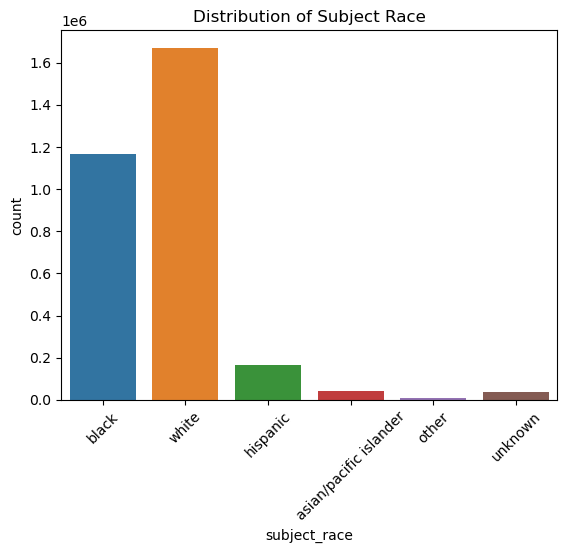

In [23]:
sns.countplot(data=df, x='subject_race')
plt.title('Distribution of Subject Race')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.show()

Per the US Census Bureau, the racial composition of Tennesseee for our three largest values are 59.1% White, 26.8% Black, 10.8% Hispanic or Latino. (https://www.census.gov/quickfacts/fact/table/nashvilledavidsonmetropolitangovernmentbalancetennessee/PST045222) When we compare these values to our dataset we get the following

In [24]:
white_perc = (df[df['subject_race'] == 'white'].shape[0] / df.shape[0])*100
black_perc = (df[df['subject_race'] == 'black'].shape[0] / df.shape[0])*100
hispanic_perc = (df[df['subject_race'] == 'hispanic'].shape[0] / df.shape[0])*100
print("White: {:.2f}%, Black: {:.2f}%, Hispanic: {:.2f}%".format(white_perc, black_perc, hispanic_perc))

White: 54.03%, Black: 37.70%, Hispanic: 5.33%


According to this preliminary data, White people are slightly underrepresented in traffic stops, Black people are significantly overrepresented by around 40% more than expected by demographic breakdown, and Hispanic people are greatly underrepresented, at nearly half the rate of the general population. Next, let's begin taking a look at the outcomes themselves

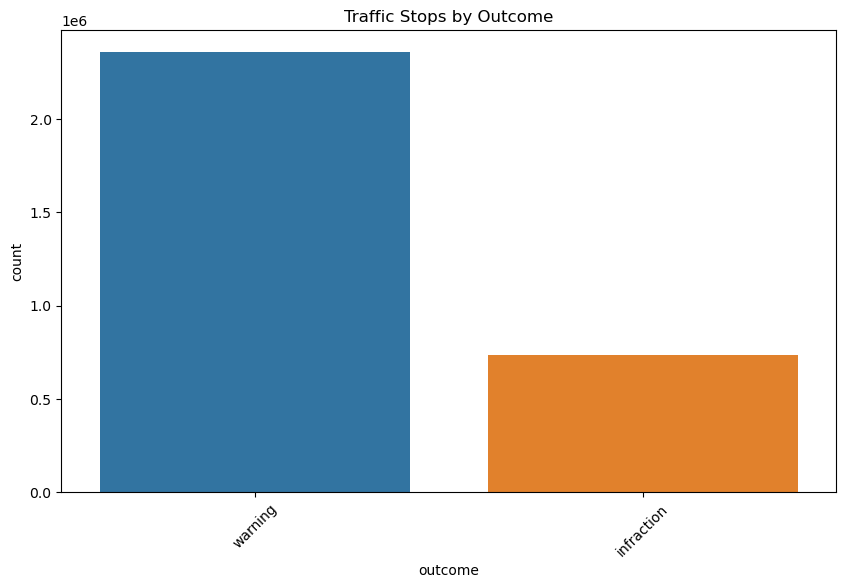

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='outcome', order = df['outcome'].value_counts().index)
plt.title('Traffic Stops by Outcome')
plt.xticks(rotation=45)
plt.show()

Distribution by Violation

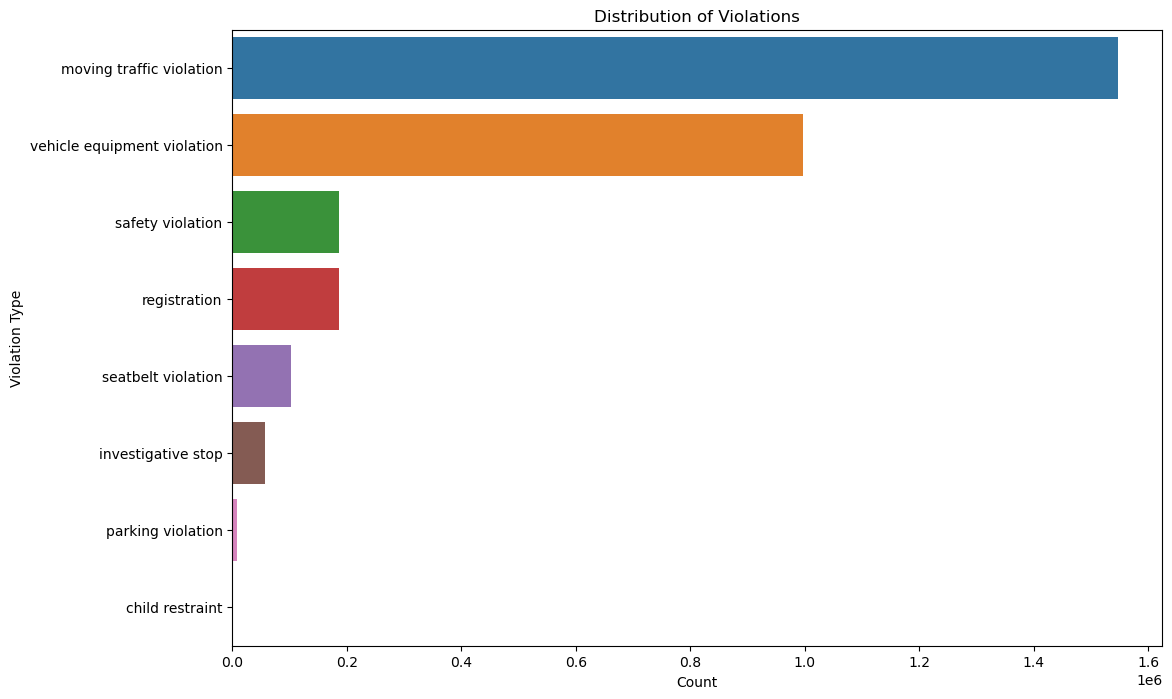

In [26]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, y='violation', order=df['violation'].value_counts().index)
plt.title('Distribution of Violations')
plt.xlabel('Count')
plt.ylabel('Violation Type')
plt.show()

Ratios of Infractions to Warnings by Race

Ratio of infractions to warnings by race:
subject_race
asian/pacific islander    0.248405
black                     0.290060
hispanic                  0.597406
other                     0.457387
unknown                   0.417730
white                     0.300546
Name: infraction_to_warning_ratio, dtype: float64


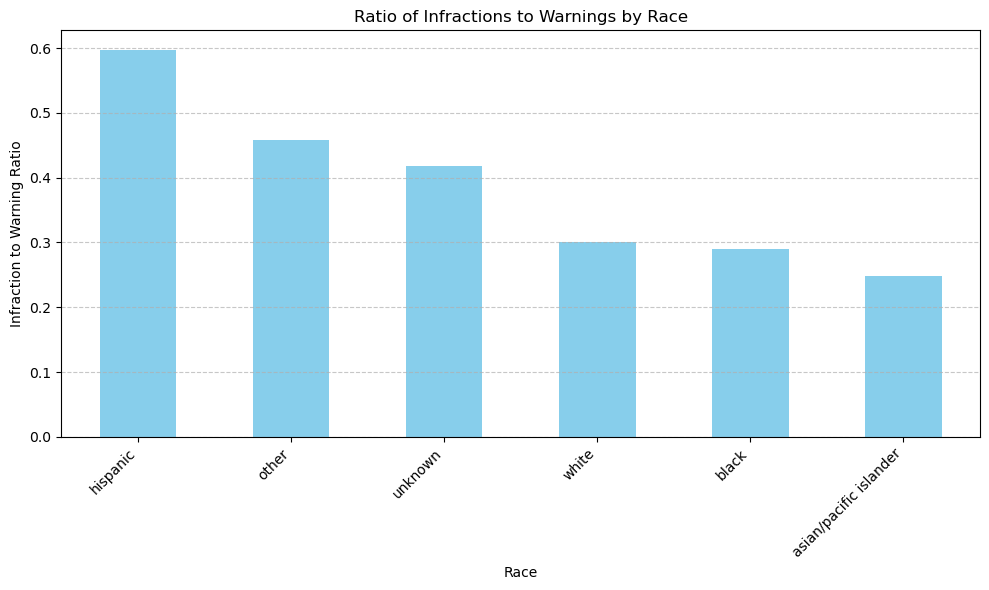

In [27]:
outcome_counts = df.groupby('subject_race')['outcome'].value_counts().unstack(fill_value=0)

outcome_counts['infraction_to_warning_ratio'] = outcome_counts['infraction'] / outcome_counts['warning']

print("Ratio of infractions to warnings by race:")
print(outcome_counts['infraction_to_warning_ratio'])

outcome_counts_sorted = outcome_counts.sort_values(by='infraction_to_warning_ratio', ascending=False)

plt.figure(figsize=(10, 6))
outcome_counts_sorted['infraction_to_warning_ratio'].plot(kind='bar', color='skyblue')
plt.title('Ratio of Infractions to Warnings by Race')
plt.xlabel('Race')
plt.ylabel('Infraction to Warning Ratio')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

These initial evaluations of our data imply that despite being underrepresented in total number of stops, Hispanic people are more likely to receive a citation or be arrested during a stop. 

## Methods

Everything that follows was a process of trial and error. Our dataset presented some challenges as we investigated the best 
model to train for our predictions. In particular the overwhelming amount of categorical features made things difficult. For instance, the officer_id_hash feature has 2,295 unique values. If we were to use onehot encoding, this would make our dataset very wide.

As we looked at models, LogisticRegression was considered and we cleaned and engineered our data for that type of model. This included one-hot encoding what we could, scaling features and dropping categorical features that didn't make any sense. Our results were barely better than just guessing "warning" for every outcome.

KNNClassifier gave slightly better results, however proved to be mostly unusable based on our sample size of 3million+.

We explored the DecisionTreeClassifier. Going into the project we figured this would be our model. It deals with categorical data well, so we didn't have to drop as many features, however, it does not deal with nan values. So, after cleaning nan values the best we could, we ended up with 2.7million samples, which was fine. However, we couldn't get the model to do much better than 79%, which is a  2% improvement on our baseline of guessing "warning" for every outcome. This testing was done with gridsearch and feature sweeping.

After a suggestion from the professor, we looked into HistGradientBoostingClassifier. This model is a bit of a black box for us, and a huge jump from the basic models we learned this semester. However it offers a lot of advantages. It works very well with categorical data, it works around nan values, and it is optimized for speed on large datasets. Without any feature selection or hyper-paramter tuning the model gave us around 85%, which was way better than our previous models.

All of the following data engineering is based around our use of this model.

In [28]:
df_encoded = df.copy()
df_encoded['precinct'] = pd.to_numeric(df_encoded['precinct'], errors='coerce')
df_encoded['zone'] = pd.to_numeric(df_encoded['zone'], errors='coerce')

There were a few typos in the precinct and zone features, so we are converting them to numeric and coercing the errors to nan since our model will handle them just fine.

The HistBoostGradient model works really well with categorical features, so we are using an OrdinalEncoder to convert our categorical features to numerical representations.

In [29]:
ord_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

cat_columns = [
    'date',
    'time',
    'precinct',
    'zone',
    'subject_race',
    'subject_sex',
    'officer_id_hash',
    'violation',
    'outcome',
    'frisk_performed',
    'search_conducted',
    'search_person',
    'search_vehicle',
    'vehicle_registration_state',
    'zip_code',
    'day_of_week',
    'month',
    'day_of_month'
    ]

df_encoded[cat_columns] = ord_encoder.fit_transform(df_encoded[cat_columns])

Using GridSearchCV we found the best setting for our model were learning_rate=0.6, max_depth=8. This model is a little confusing for us, but we understand max_depth.

Once we had our best hyper-parameters we did a feature sweep and found that 'day_of_month', 'search_conducted' and 'day_of_week' were noisy features. Our final feature set looks like this:
['subject_sex','search_vehicle','subject_race','month','zip_code','lat','officer_id_hash', 'reporting_area', 'search_person', 'date', 'violation', 'time', 'subject_age', 'frisk_performed', 'lng', 'zone', 'precinct', 'vehicle_registration_state']. All that is left is to train and test this model


In [30]:
selected_features =['subject_sex','search_vehicle','subject_race','month','zip_code','lat','officer_id_hash', 'reporting_area', 'search_person', 'date', 'violation', 'time', 'subject_age', 'frisk_performed', 'lng', 'zone', 'precinct', 'vehicle_registration_state']

X = df_encoded[selected_features]
y = df_encoded['outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)


hist_gradient = HistGradientBoostingClassifier(learning_rate=0.6, max_depth=8)
hist_gradient.fit(X_train, y_train)


hist_gradient.score(X_test, y_test)

0.8467510181027179

## Results and Discussion

As you can see, we got close to 85% accuracy using this model. This model was a vast improvement over all the other models. However, one down side is that the model is not very interpretable. It is difficult to figure out which features had the largest
effect, as is the case for most "black box" models, but luckily the sklearn toolkit includes some testing of permutations of the model to determine which features were most predictive. 

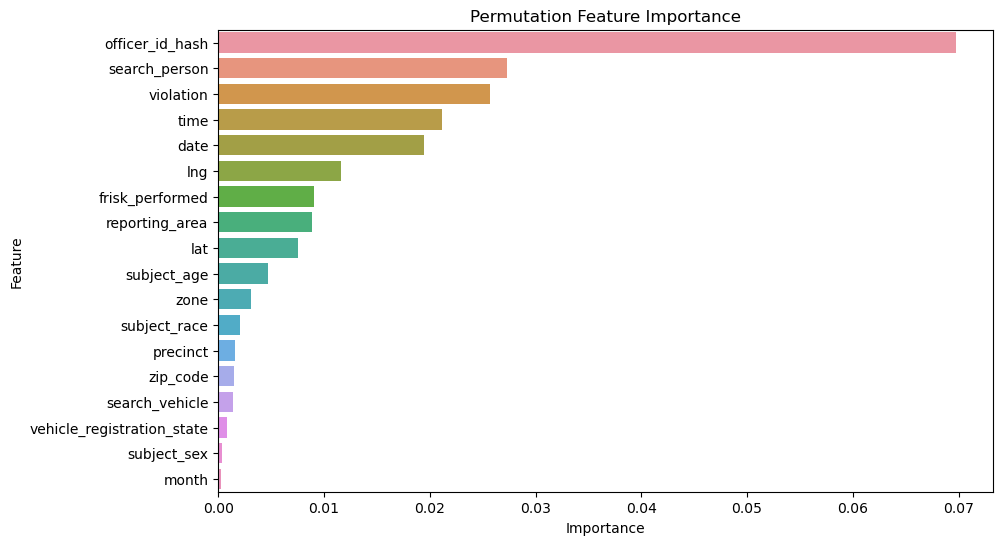

In [31]:
perm_importance = permutation_importance(hist_gradient, X_test, y_test, n_repeats=30, random_state=42)

feature_names = X_test.columns

fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': perm_importance.importances_mean})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df)
plt.title('Permutation Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

These results were surprising to us, because despite the clear disparities in policing outcomes by race in the data at large and in general, any particular outcome is more strongly predicted by the individual officer who performs the stops, followed by if your traffic stop was escalated to include a search, then by the kind of violation you were stopped for. So to summarize, racial bias in policing is evident from the data as a whole, but the zealousness or permissiveness of particular officers are a much stronger predictor of whether someone gets a ticket or not.